# Funzioni

In [33]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import seaborn as sns

def idx2path(index, len_output_path = 10):
    binario = [int(bit) for bit in bin(index)[2:]]
    codifica_binaria = [0] * (len_output_path - len(binario)) + binario[-len_output_path:]
    return codifica_binaria

def path2idx(path):
    return int(''.join(map(str, path)), 2)

def inv_G0(p):
    return p

def count_data_in_B(data, B):
    sum = 0
    for i in range(len(data)):
      if data[i] >= B[0] and data[i] <= B[1]:
        sum = sum + 1
    return sum

def sample_beta(a,b, size = 1):
    if size == 1:
      return np.random.beta(a, b, size=size)[0]
    else:
      return np.random.beta(a, b, size=size)

In [34]:
def polya_tree_posterior(data, c = 5, depth = 10):
    all_B = [[0,1]]
    all_alpha = [np.zeros(1)]
    for m in range(1, depth + 1):
      k = int(2 ** m)
      all_B_m = np.zeros((k, 2))
      all_alpha_m = np.zeros(k)
      for i in range(k):
        if i == 0:
          all_B_m[i,0] = 0
        else:
          all_B_m[i,0] = inv_G0(i/k)

        if i == k-1:
          all_B_m[i,1] = 1
        else:
          all_B_m[i,1] = inv_G0((i+1)/k)

        all_alpha_m[i] = c * (m**2) + count_data_in_B(data, all_B_m[i,:])

      all_B.append(all_B_m)
      all_alpha.append(all_alpha_m)

    return all_alpha, all_B

In [35]:
def sample_from_polya_tree(all_alpha):
    all_p = [1]
    depth = len(all_B) - 1
    for m in range(1,depth+1):
      k = int(2 ** m)
      all_p_m = np.zeros(k)
      all_alpha_m = all_alpha[m]
      i = 0
      while i < k:
        p = sample_beta(all_alpha_m[i], all_alpha_m[i+1])
        all_p_m[i] = p
        all_p_m[i + 1] = 1 - p
        i = i + 2
      all_p.append(all_p_m)
    N = 2 ** depth
    return_probs = np.zeros(N)
    for i in range(N):
      final_p = 1
      path = idx2path(i, len_output_path = depth)
      for m in range(1,depth + 1):
        all_p_m = all_p[m]
        final_p = final_p * all_p_m[path2idx(path[:m])]
      return_probs[i] = final_p
    return all_p, return_probs

In [36]:
def compute_predictive(all_alpha, all_B):
  depth = len(all_B) - 1
  k = 2 ** depth
  predictive_prob = np.zeros(k)
  for i in range(k):
    prob = 1
    path = idx2path(i, len_output_path=depth)
    for m in range(1, depth+1):
      index = path2idx(path[:m])
      if index % 2 == 0:
        prob = prob * all_alpha[m][index]/(all_alpha[m][index] + all_alpha[m][index+1])
      else:
        prob = prob * all_alpha[m][index]/(all_alpha[m][index] + all_alpha[m][index-1])

    predictive_prob[i] = prob
  return predictive_prob

In [37]:
def sample_from_categorical_distribution(intervals, probabilities, n):
  sampled_points = np.zeros(n)
  for i in range(n):
    selected_interval_index = np.random.choice(len(intervals), p=probabilities)
    selected_interval = intervals[selected_interval_index]
    sample = np.random.uniform(selected_interval[0], selected_interval[1])
    sampled_points[i] = sample
  return sampled_points

# Plot di 30 densità ~ $ PT(G_0, (A | \vec y)) ,  G_0 = U_{[0,1]} $ , della loro media campionaria, e della predittiva $ P(y_{n+1} | \vec y) $




In [43]:
sample_size = 10000

sample = sample_beta(2,2,size = sample_size)                 # y ~ beta(2,2)
# sample = sample_beta(10,1,size = sample_size)                # y ~ beta(10,1)
# sample = np.random.uniform(0, 1/4, sample_size)              # y ~ Unif(0, 0.25)

c = 10
all_alpha, all_B = polya_tree_posterior(data = sample, c = c, depth = 10)
final_intervals = all_B[-1]

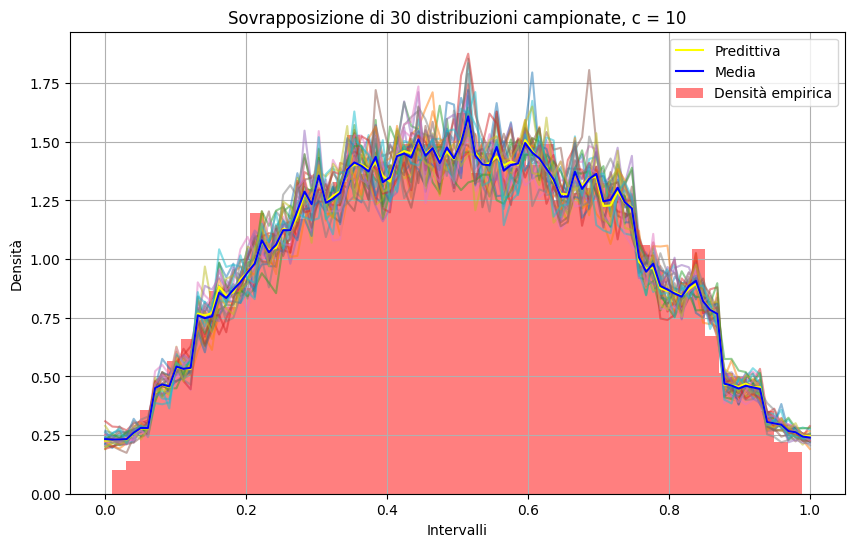

In [44]:
sampled_distributions = []

mean = 0
num_samples = 30
for _ in range(num_samples):
    _, sampled_distribution = sample_from_polya_tree(all_alpha)
    sampled_distributions.append(sampled_distribution)
    mean = mean + sampled_distribution

mean = mean/num_samples

final_intervals = all_B[-1]
x_points = (final_intervals[:, 0] + final_intervals[:, 1]) / 2
plt.figure(figsize=(10, 6))

widths = np.diff(final_intervals, axis=1).flatten()

# Plotta ogni distribuzione campionata
for sampled_distribution in sampled_distributions:
    area = np.sum(sampled_distribution * widths)
    normalized_distribution = sampled_distribution / area
    f = interp1d(x_points, normalized_distribution, kind='linear', fill_value="extrapolate")
    x_interp = np.linspace(final_intervals[0, 0], final_intervals[-1, 1], 100)
    y_interp = f(x_interp)
    plt.plot(x_interp, y_interp, alpha=0.5)

# Plot della predittiva
sampled_distribution = compute_predictive(all_alpha, all_B)
area = np.sum(sampled_distribution * widths)
normalized_distribution = sampled_distribution / area
f = interp1d(x_points, normalized_distribution, kind='linear', fill_value="extrapolate")
x_interp = np.linspace(final_intervals[0, 0], final_intervals[-1, 1], 100)
y_interp = f(x_interp)
plt.plot(x_interp, y_interp, alpha=1, color = "yellow", label = "Predittiva")

# Plot della media
area = np.sum(sampled_distribution * widths)
sampled_distribution = mean
normalized_distribution = sampled_distribution / area
f = interp1d(x_points, normalized_distribution, kind='linear', fill_value="extrapolate")
x_interp = np.linspace(final_intervals[0, 0], final_intervals[-1, 1], 100)
y_interp = f(x_interp)
plt.plot(x_interp, y_interp, alpha=1, color = "blue", label = "Media")


plt.hist(sample, color='red', label='Densità empirica', bins = 50, density = True, alpha = 0.5)

# Aggiungi etichette e titolo
plt.xlabel("Intervalli")
plt.ylabel("Densità")
plt.title(f"Sovrapposizione di {num_samples} distribuzioni campionate, c = {c}")
plt.legend()
plt.grid()
plt.show()

# Sampling di $ n $ punti dalla predittiva $ P(y_{n+1} | \vec y) $

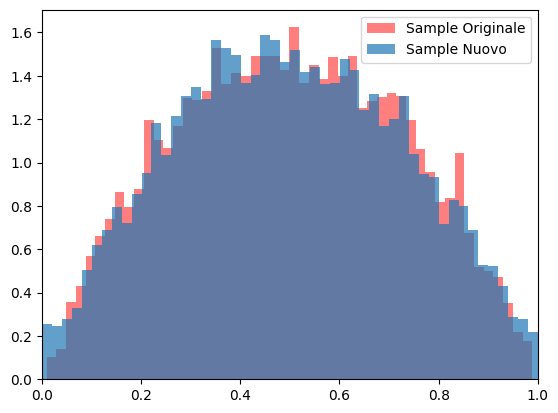

In [45]:
n = 10000
predictive = compute_predictive(all_alpha, all_B)
sample_new = sample_from_categorical_distribution(intervals = final_intervals, probabilities = predictive, n = n)
plt.hist(sample, color='red', label='Sample Originale', bins = 50, density = True, alpha = 0.5)
plt.hist(sample_new, label = "Sample Nuovo", bins = 50, density = True, alpha = 0.7)

plt.legend()
plt.xlim(0,1)
plt.show()